# **Clothes Detection Using YOLOv8 & YOLOv10**

### **Dataset**

This notebook explains training custom YOLOv8 & YOLOv10 models for object detection. We are using "fashion-dataset-with-annotation" Dataset from kaggle which is already available in yolo format.
https://www.kaggle.com/datasets/lahbibfedi/fashion-dataset-with-annotation

*The data has 13 classes:*
1. short_sleeved_shirt
2. long_sleeved_shirt
3. short_sleeved_outwear
4. long_sleeved_outwear
5. vest
6. sling
7. shorts
8. trousers
9. skirt
10. short_sleeved_dress
11. long_sleeved_dress
12. vest_dress
13. sling_dress

In [ ]:
!kaggle datasets download -d lahbibfedi/fashion-dataset-with-annotation
!unzip -q fashion-dataset-with-annotation.zip -d /content/

Dataset URL: https://www.kaggle.com/datasets/lahbibfedi/fashion-dataset-with-annotation
License(s): unknown
100% 625M/627M [00:28<00:00, 24.4MB/s]
100% 627M/627M [00:28<00:00, 23.4MB/s]


#### You should prepare the data for the training

Changing the diractory of data file into the root.

In [ ]:
%mkdir images
%mkdir labels
%cp -r "/content/new_train (1)/new_t/labels/" "/content/labels/"
%mv "/content/labels/labels" "/content/labels/train"
%cp -r "/content/new_validation (1)/new_v/labels" "/content/labels"
%mv "/content/labels/labels" "/content/labels/val"
%cp -r "/content/new_train (1)/new_t/images/" "/content/images"
%mv "/content/images/images" "/content/images/train"
%cp -r "/content/new_validation (1)/new_v/images" "/content/images"
%mv "/content/images/images" "/content/images/val"

#### **YOLO format:**

The format for Yolov8 is same as Yolov10. The YOLO format, with one .txt file per image (if no objects in image, no .txt file is required). The *.txt file specifications are:

One row per object Each row is class x_center y_center width height format.

Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height. Class numbers are zero-indexed (start from 0).

In [ ]:
# Checking the size of images and displaying them
import numpy as np
import cv2
# Image shape in Training
image = cv2.imread('/content/images/train/000024.jpg')
height = np.size(image, 0)
width = np.size(image, 1)
print ("shape of the training image {}, {}".format(height, width))
# Image shape in validation
image = cv2.imread('/content/images/val/005753.jpg')
height = np.size(image, 0)
width = np.size(image, 1)
print ("shape of the validation image {}, {}".format(height, width))

shape of the training image 401, 640
shape of the validation image 624, 468


dispying with different width

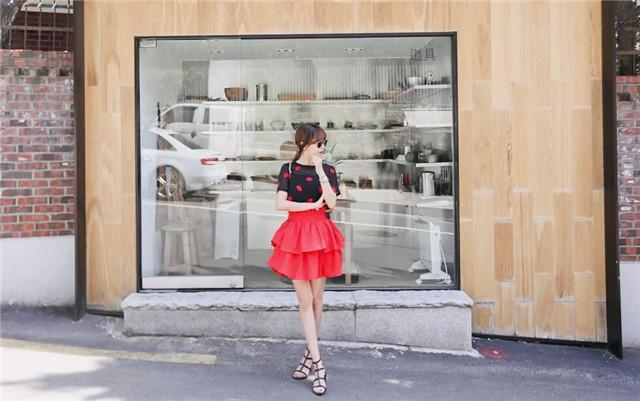

In [ ]:
from IPython.display import Image
Image(filename='/content/images/train/000024.jpg', width=700)

## **YOLOv8**

### YOLOv8 Installation:

The recent Yolov8 has been released as pip package, so we don't need to clone any repo. This package alone installs ever dependency for yolov8.

The Pip install of the ultralytics package including all requirements.txt in a Python>=3.7.0 environment, including PyTorch>=1.7.

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.7/780.7 kB 16.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

### **Create detetcion.yaml (dataset config file)**

Our dataset is having the images are split as follows:
Train: 8000 = 80%
Valid: 2000 = 20%
Total = 10000 images

detection.yaml, created below, is the dataset config file that defines:

the dataset root directory path and relative paths to train / val / test image directories (or *.txt files with image paths)

nc: the number of classes

names: a list of class names

In [ ]:
%%writefile -a /content/detection.yaml

# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
train: /content/images/train/
val: /content/images/val/

#Classes
nc: 13
#classes names
#replace all class names list with your classes names
names: ["short_sleeved_shirt","long_sleeved_shirt","short_sleeved_outwear","long_sleeved_outwear","vest","sling","shorts","trousers","skirt","short_sleeved_dress","long_sleeved_dress","vest_dress","sling_dress"]

Writing /content/detection.yaml


### **Training Our Custom Clothes Detetcion Model:**

We are using a YOLOv8m pre-trained model for custom training with our dataset.

Parameters:
*   specify the path to the data configuration file
*   specify a path to weights to start transfer learning from. yolov8m.pt (starting from pre-trained weights)
*   input image size
*   Size of a batch (model weights are updated with each batch).
*   Number of epochs.

It will cache images for faster training, cache images in "ram" (default) or "disk

In [ ]:
from ultralytics import YOLO

# Load a pretrained model
model = YOLO("yolov8m.pt")

# train the model
results = model.train(data="/content/detection.yaml", epochs=25, imgsz=640)  

100%|██████████| 49.7M/49.7M [00:00<00:00, 249MB/s]


Ultralytics YOLOv8.2.30 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/detection.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 14.9MB/s]


Overriding model.yaml nc=80 with nc=13

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 6.23M/6.23M [00:00<00:00, 62.4MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/labels/train... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:15<00:00, 661.07it/s]


train: New cache created: /content/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/labels/val... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:04<00:00, 480.16it/s]


val: New cache created: /content/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      7.17G     0.9281      1.965      1.347         56        640: 100%|██████████| 625/625 [06:06<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:32<00:00,  1.93it/s]

                   all       2000       3313      0.585      0.412      0.391       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      7.04G     0.9731      1.649      1.363         55        640: 100%|██████████| 625/625 [05:56<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:30<00:00,  2.07it/s]


                   all       2000       3313      0.515      0.421      0.373      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      7.11G     0.9778      1.606      1.362         66        640: 100%|██████████| 625/625 [05:50<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:30<00:00,  2.05it/s]


                   all       2000       3313       0.57       0.44      0.455      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      7.11G     0.9535      1.528       1.34         56        640: 100%|██████████| 625/625 [05:49<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:28<00:00,  2.23it/s]


                   all       2000       3313      0.667      0.451      0.471      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      7.11G     0.8995      1.425      1.304         51        640: 100%|██████████| 625/625 [05:48<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]


                   all       2000       3313      0.569      0.524      0.503      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      7.03G     0.8686      1.347      1.281         60        640: 100%|██████████| 625/625 [05:46<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:31<00:00,  2.03it/s]


                   all       2000       3313      0.692      0.499      0.519      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      7.11G      0.839      1.288      1.257         70        640: 100%|██████████| 625/625 [05:45<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:30<00:00,  2.07it/s]

                   all       2000       3313      0.701        0.5       0.53      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      7.12G     0.8188      1.241      1.246         79        640: 100%|██████████| 625/625 [05:45<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:31<00:00,  2.00it/s]

                   all       2000       3313      0.659       0.55      0.575      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      7.11G     0.7999      1.205      1.234         53        640: 100%|██████████| 625/625 [05:47<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:31<00:00,  2.01it/s]


                   all       2000       3313      0.704      0.541      0.596       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      7.01G     0.7849      1.158      1.215         53        640: 100%|██████████| 625/625 [05:47<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:30<00:00,  2.07it/s]

                   all       2000       3313      0.729      0.552      0.616        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      7.12G     0.7709      1.128      1.203         53        640: 100%|██████████| 625/625 [05:48<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:32<00:00,  1.96it/s]

                   all       2000       3313      0.694      0.567      0.609      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       7.1G     0.7553      1.091      1.194         59        640: 100%|██████████| 625/625 [05:53<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


                   all       2000       3313      0.628      0.609      0.637      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       7.1G     0.7474      1.069      1.193         51        640: 100%|██████████| 625/625 [05:46<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:29<00:00,  2.17it/s]

                   all       2000       3313      0.766       0.57      0.627      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      7.02G      0.725      1.045      1.174         59        640: 100%|██████████| 625/625 [05:46<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:31<00:00,  2.00it/s]

                   all       2000       3313      0.661      0.623      0.657      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      7.12G     0.7153      1.004       1.17         53        640: 100%|██████████| 625/625 [05:47<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:30<00:00,  2.05it/s]

                   all       2000       3313       0.76      0.553      0.638      0.531


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       7.1G     0.6417     0.7496      1.121         27        640: 100%|██████████| 625/625 [05:46<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:28<00:00,  2.19it/s]

                   all       2000       3313      0.696      0.607      0.666      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      7.08G     0.6255     0.7193      1.111         23        640: 100%|██████████| 625/625 [05:46<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:28<00:00,  2.21it/s]


                   all       2000       3313      0.706      0.592      0.658      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25         7G     0.6137     0.6814      1.099         26        640: 100%|██████████| 625/625 [05:43<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:30<00:00,  2.09it/s]

                   all       2000       3313      0.692      0.577      0.665      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      7.11G     0.6005     0.6405      1.088         28        640: 100%|██████████| 625/625 [05:50<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:32<00:00,  1.95it/s]

                   all       2000       3313      0.705      0.618      0.674      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25       7.1G     0.5823     0.6249      1.069         26        640: 100%|██████████| 625/625 [05:46<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]

                   all       2000       3313      0.629      0.647      0.674       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25       7.1G     0.5718     0.5884      1.066         28        640: 100%|██████████| 625/625 [05:45<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:30<00:00,  2.05it/s]

                   all       2000       3313       0.65      0.668      0.693      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      7.01G     0.5562     0.5492      1.052         23        640: 100%|██████████| 625/625 [05:46<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:30<00:00,  2.05it/s]

                   all       2000       3313      0.629       0.66      0.685      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      7.09G     0.5399     0.5155      1.041         29        640: 100%|██████████| 625/625 [05:44<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:31<00:00,  2.02it/s]

                   all       2000       3313       0.63      0.672      0.696      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       7.1G     0.5298     0.4898      1.033         26        640: 100%|██████████| 625/625 [05:42<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


                   all       2000       3313      0.721      0.635      0.706      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      7.11G     0.5155     0.4586      1.025         25        640: 100%|██████████| 625/625 [05:43<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


                   all       2000       3313      0.687      0.645      0.711       0.61

25 epochs completed in 2.666 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.30 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25847287 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]


                   all       2000       3313      0.687      0.645      0.711       0.61
   short_sleeved_shirt        796        806      0.848      0.866      0.933      0.823
    long_sleeved_shirt        345        347      0.729      0.709       0.78      0.682
 short_sleeved_outwear         13         13      0.545      0.231      0.326      0.306
  long_sleeved_outwear        111        111       0.61      0.776      0.792      0.686
                  vest        162        163      0.686      0.711      0.773      0.631
                 sling         31         32      0.629      0.188      0.397      0.284
                shorts        269        269       0.83      0.792      0.861      0.714
              trousers        605        610      0.869       0.91       0.94      0.769
                 skirt        419        419      0.772      0.811      0.848      0.727
   short_sleeved_dress        180        181      0.687      0.674      0.764        0.7
    long_sleeved_dres

### Load the model to work with

In [ ]:
from ultralytics import YOLO
model = YOLO("best.pt")

### **Val:**

Validate trained YOLOv8 model accuracy on the validation dataset. No argument needs to be passed as the model retains its training data and arguments as model attributes.

Evaluate model performance on the validation set

In [ ]:
results = model.val()

Ultralytics YOLOv8.2.30 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25847287 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/labels/val.cache... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:46<00:00,  2.66it/s]


                   all       2000       3313      0.682      0.646      0.711      0.609
   short_sleeved_shirt        796        806      0.851      0.866      0.933      0.823
    long_sleeved_shirt        345        347      0.728      0.712      0.782      0.684
 short_sleeved_outwear         13         13       0.54      0.231      0.325      0.305
  long_sleeved_outwear        111        111      0.614      0.775      0.791      0.682
                  vest        162        163      0.689      0.712      0.775      0.632
                 sling         31         32      0.551      0.192      0.397      0.285
                shorts        269        269      0.829      0.792       0.86      0.714
              trousers        605        610      0.871      0.911       0.94      0.769
                 skirt        419        419      0.772      0.814      0.847      0.727
   short_sleeved_dress        180        181      0.684      0.669      0.764      0.701
    long_sleeved_dres

### **Metrics:**
The training mAP(mean average precision) per class and the overall is good. If we train for epochs, adding more data and playing with hyperparameters can improve the performance of the model.

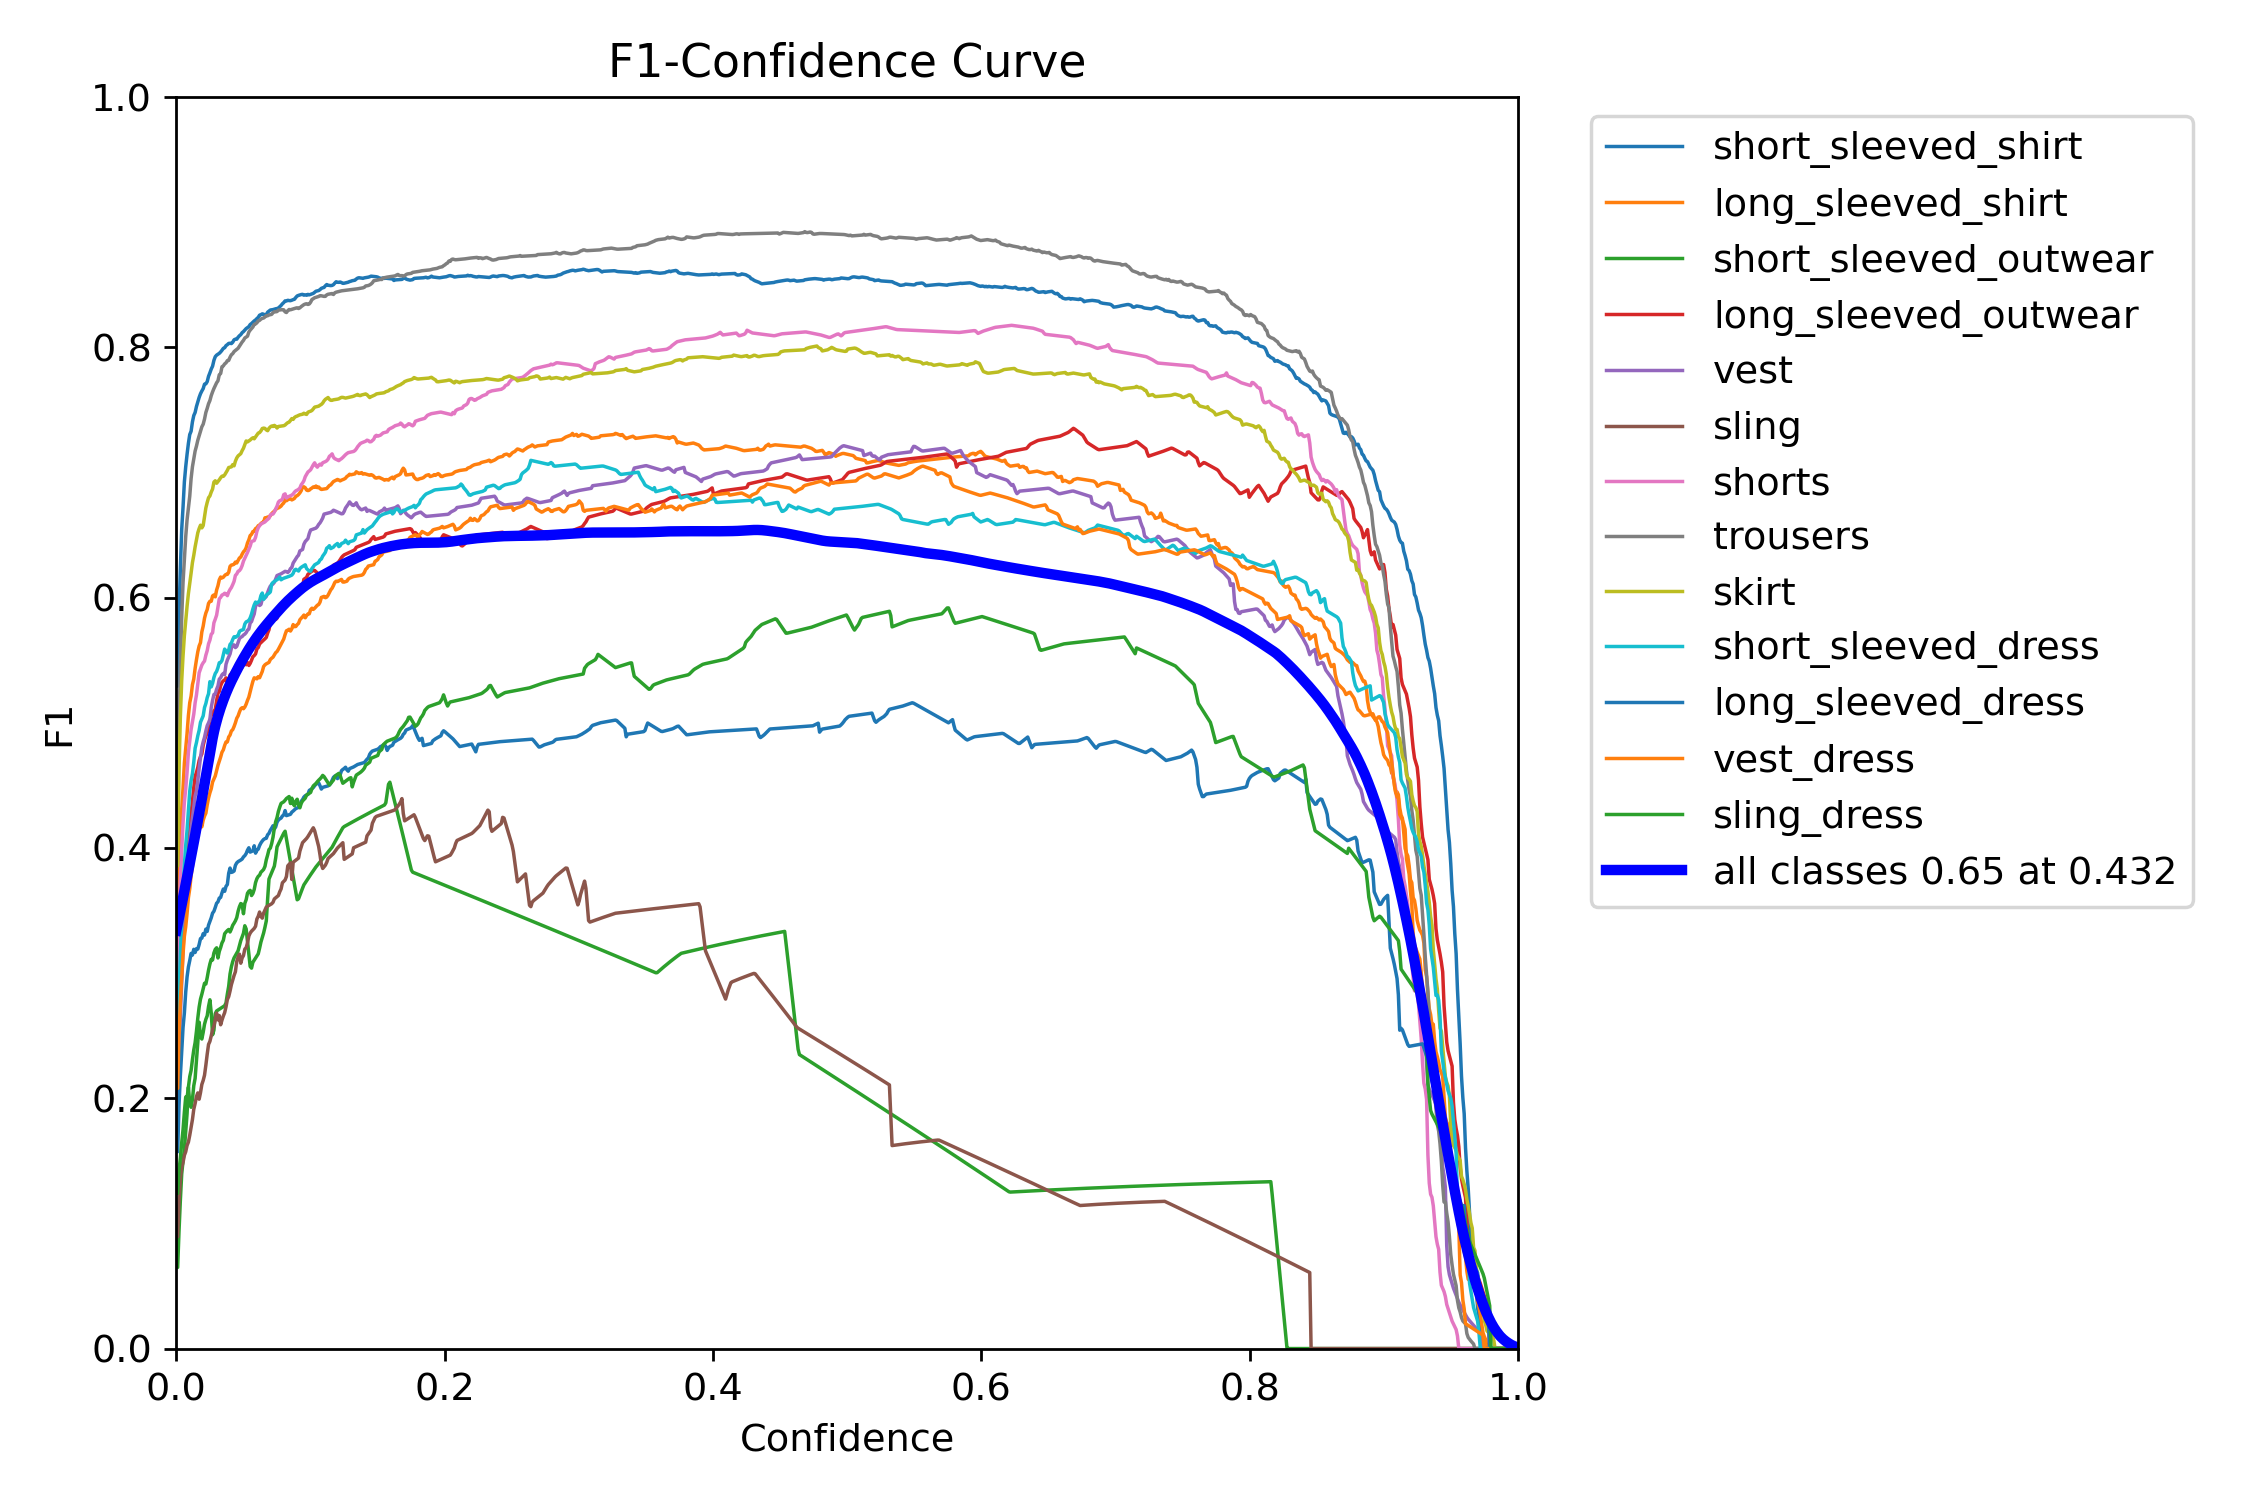

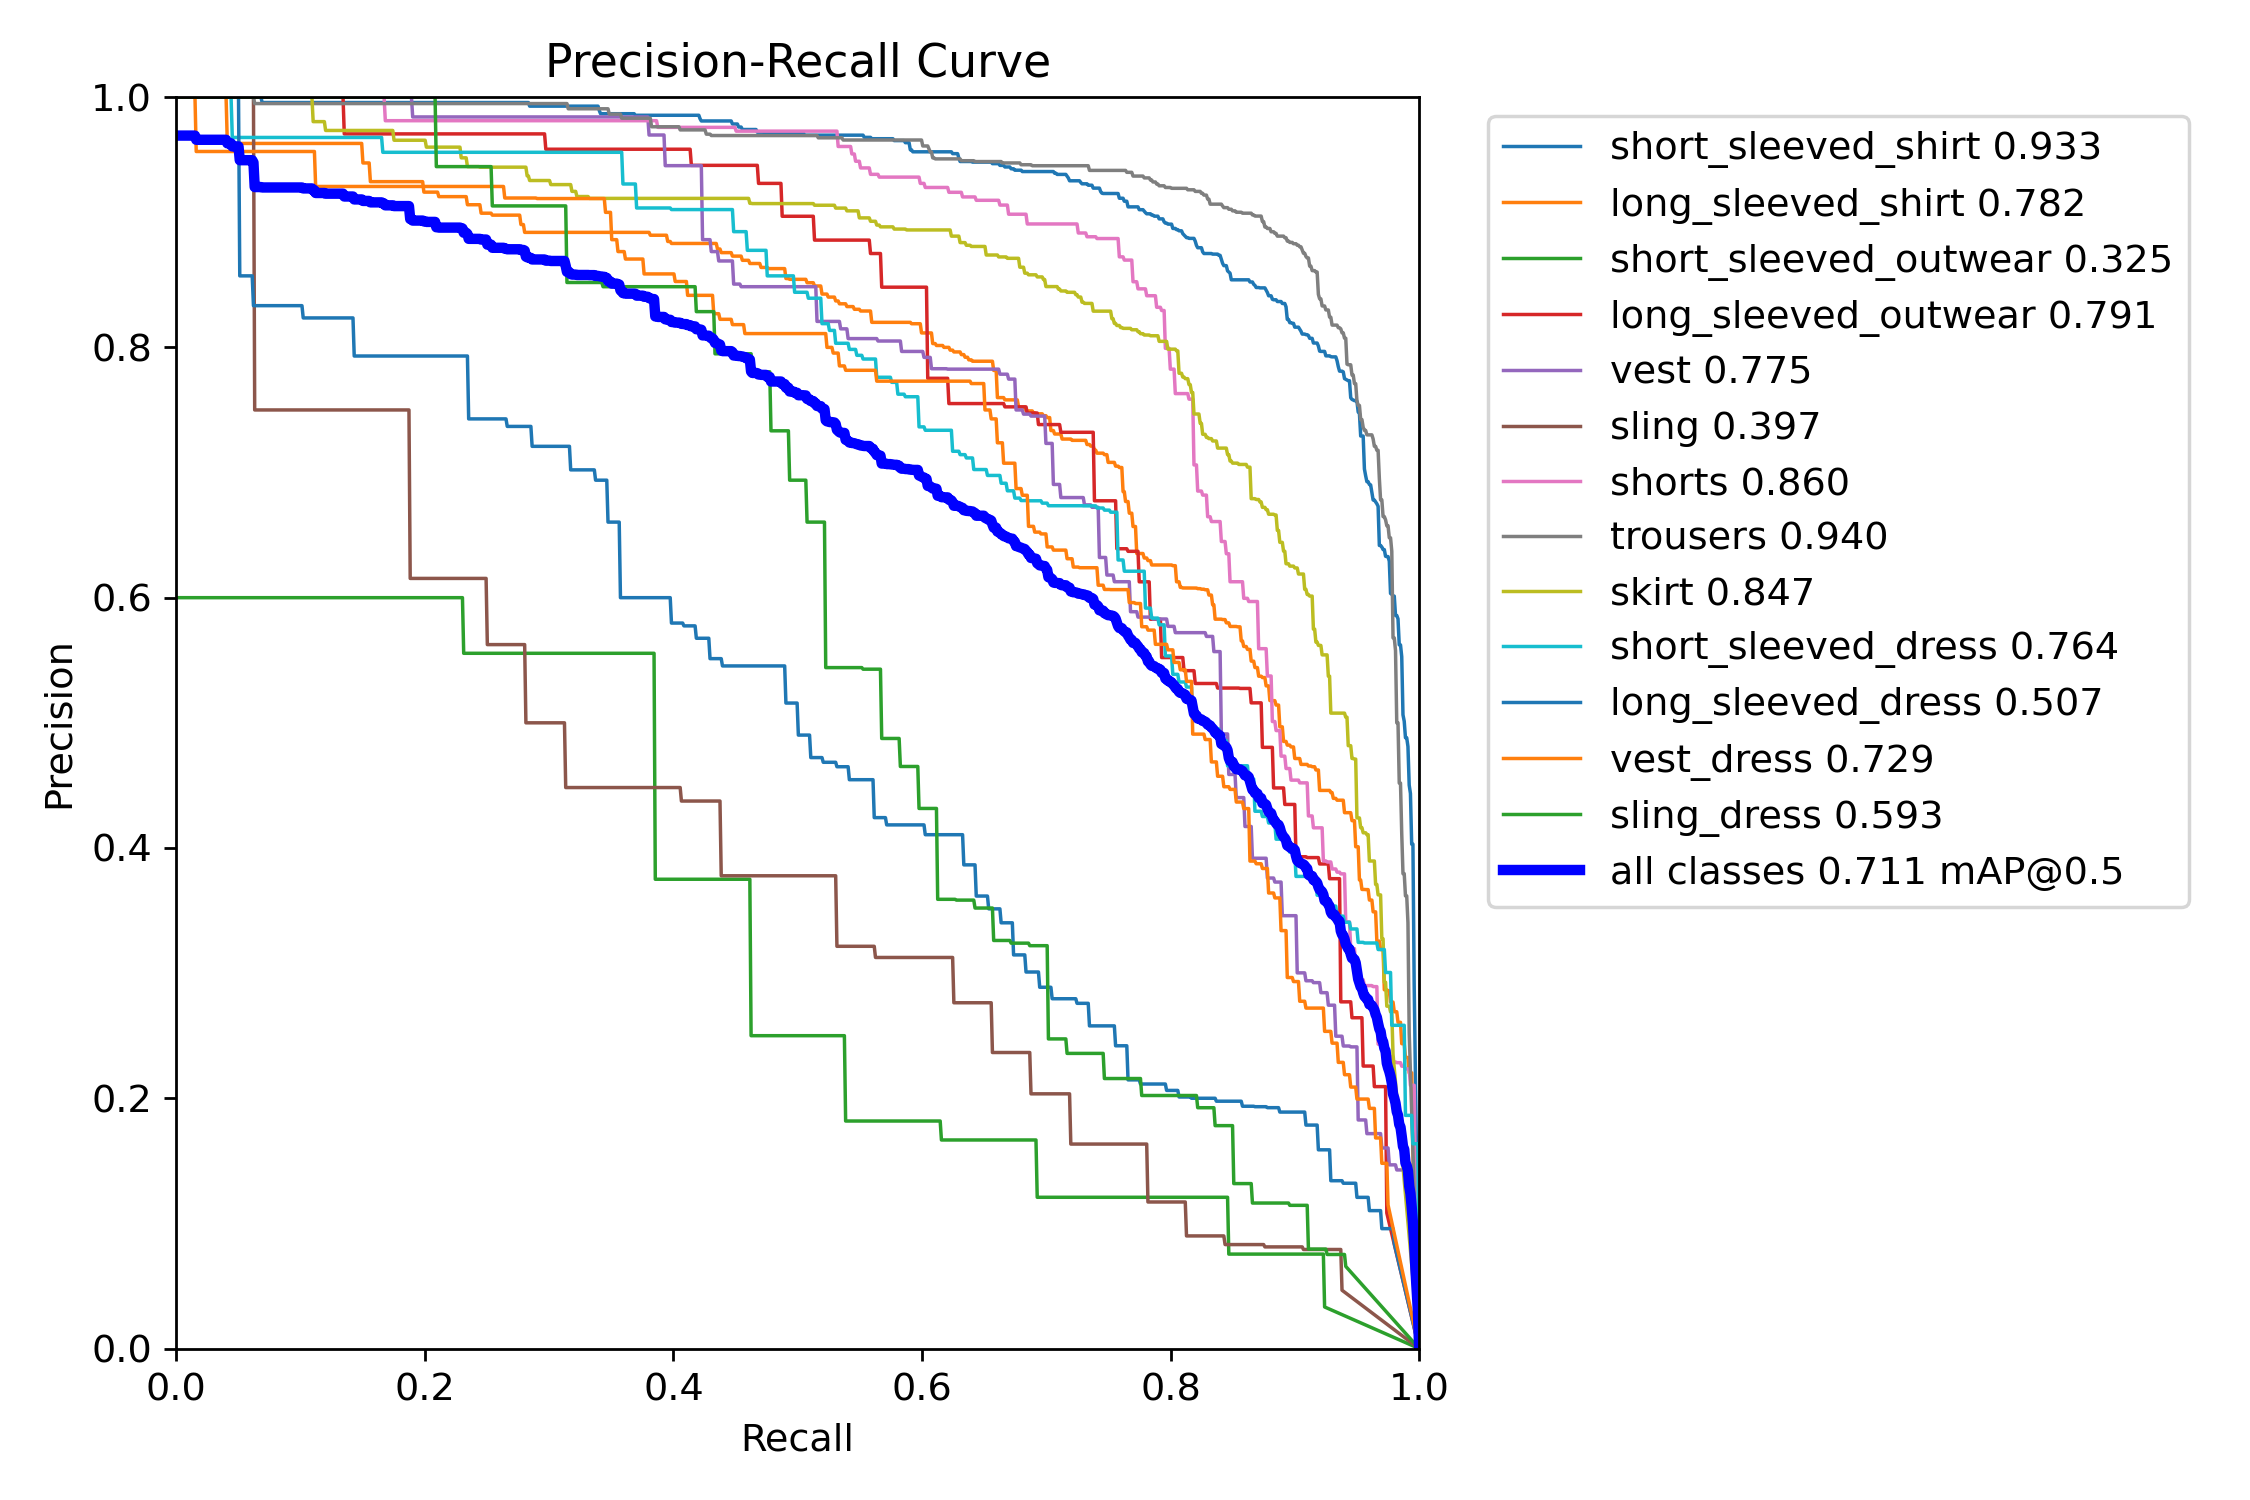

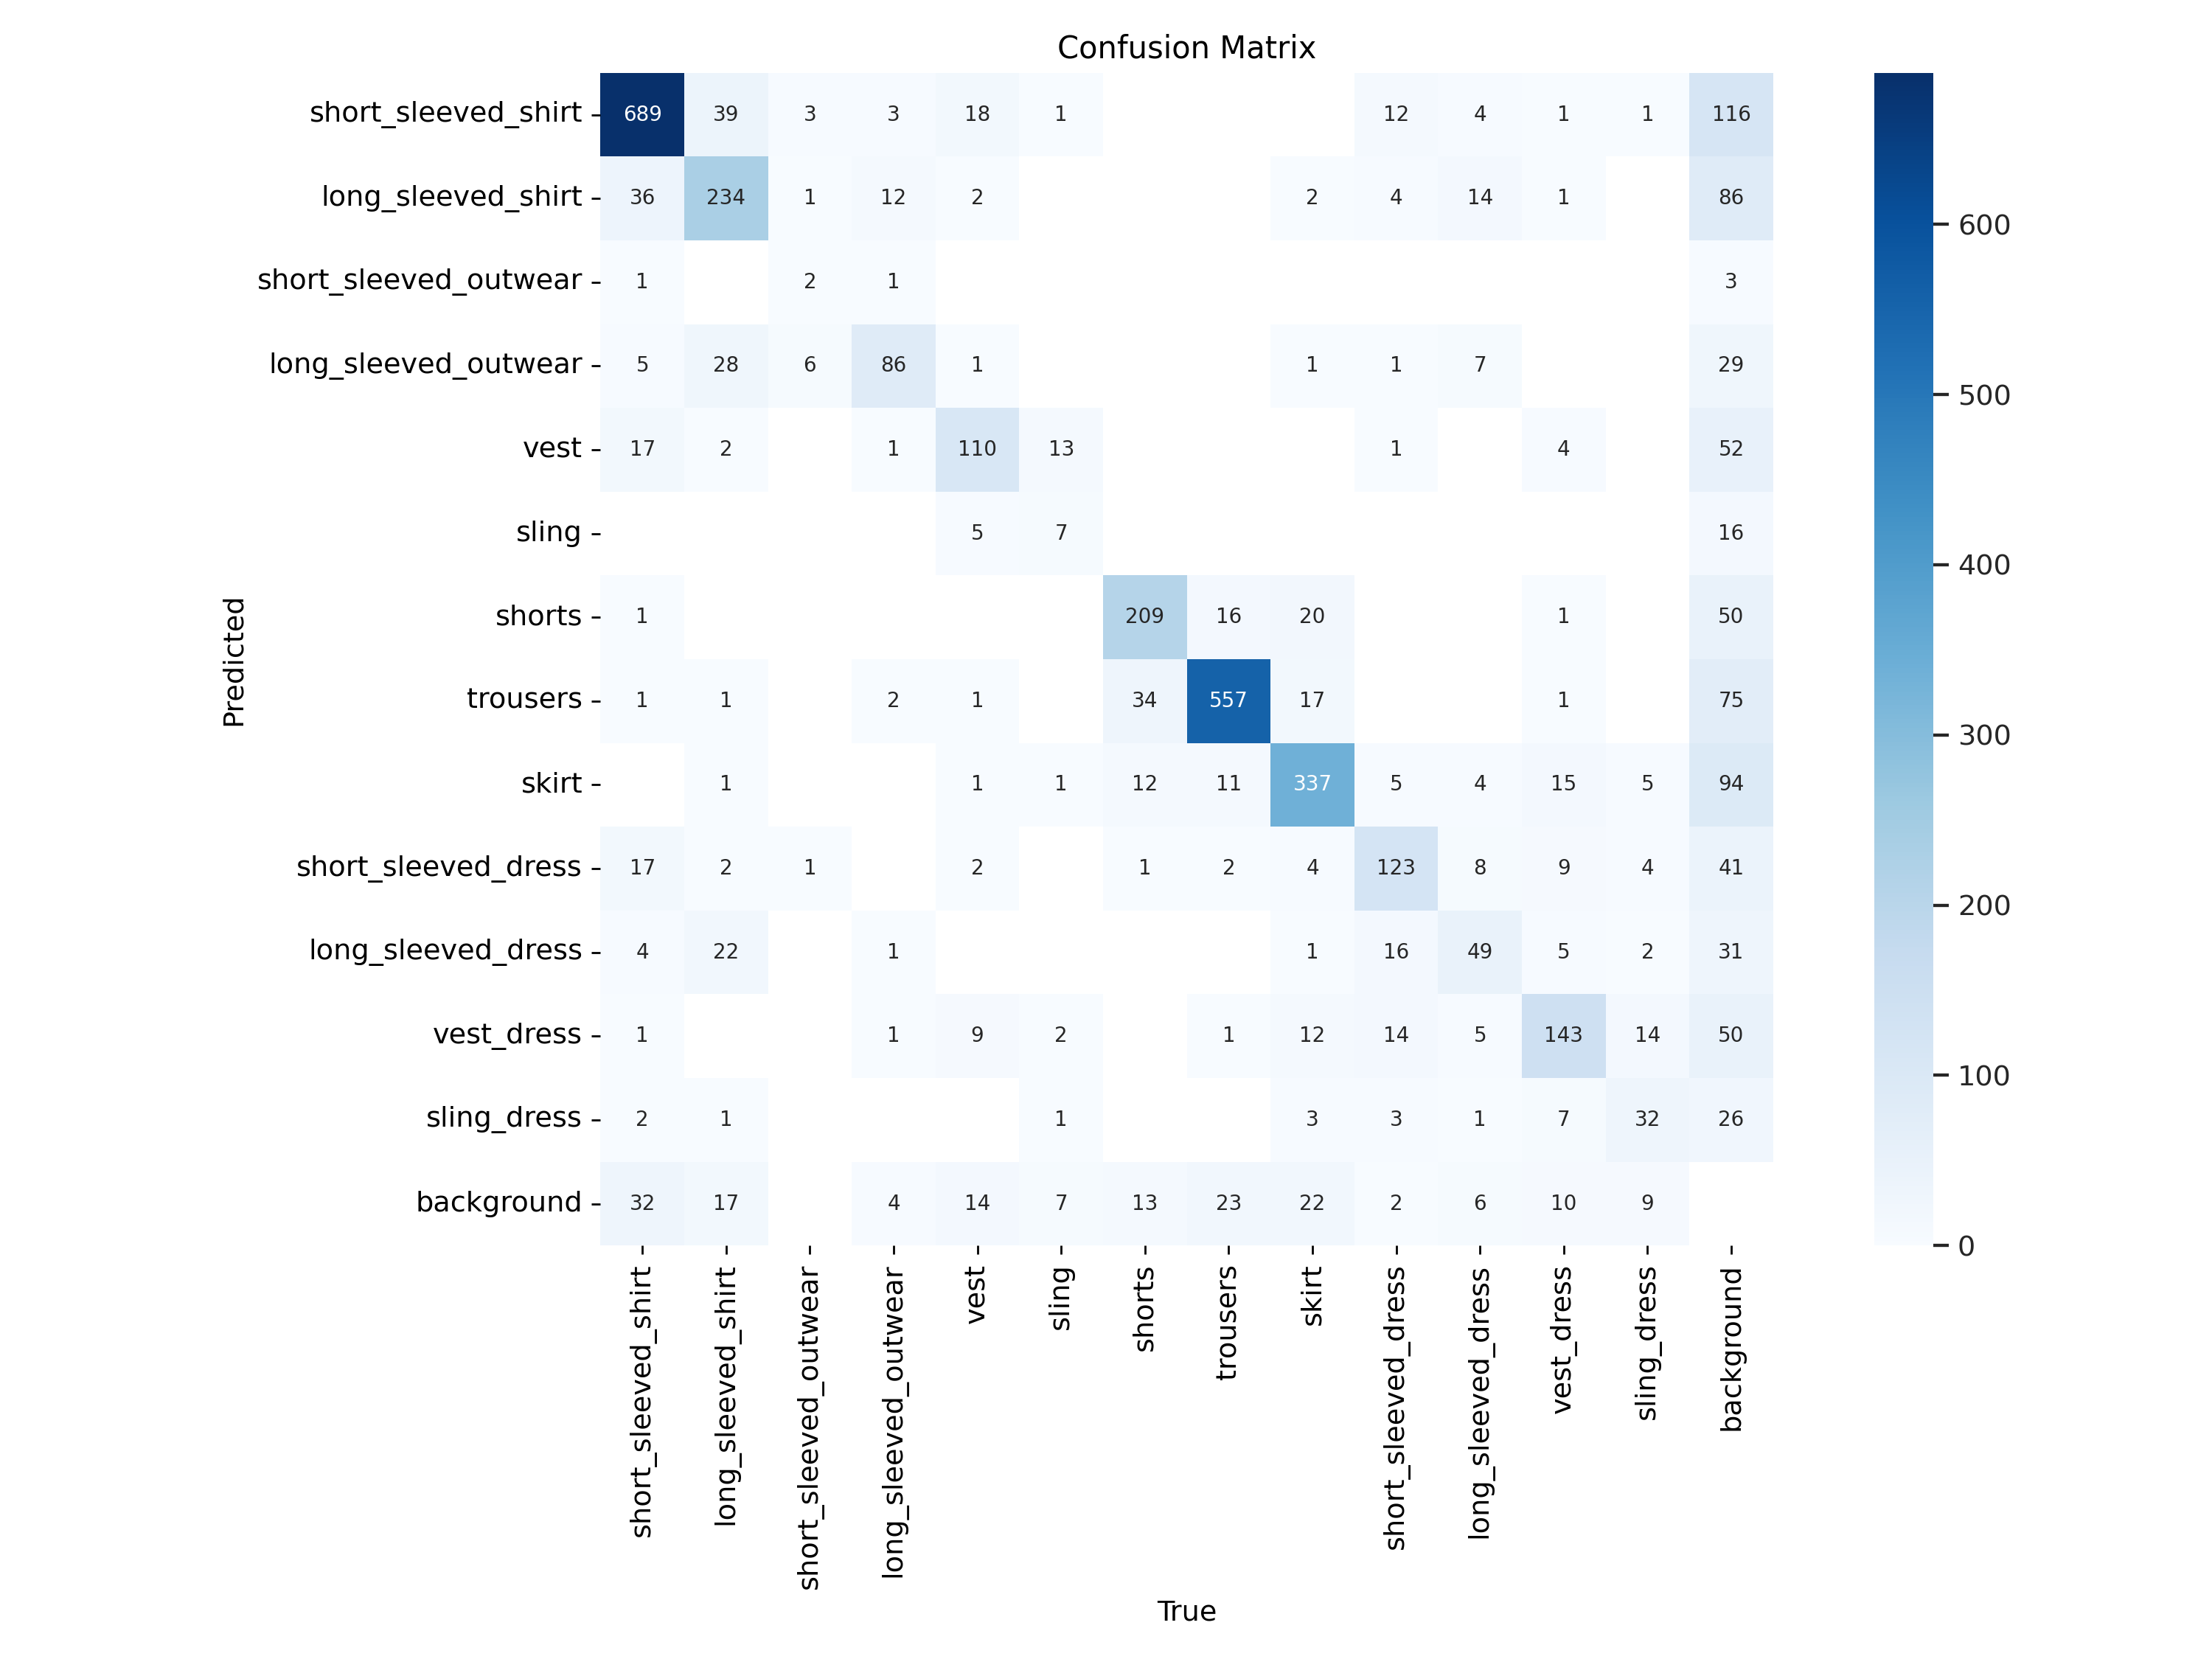

In [ ]:
# dislaying metrics for train data
from IPython.display import Image
from IPython.display import display
x = Image(filename='/content/runs/detect/train2/F1_curve.png')
y = Image(filename='/content/runs/detect/train2/PR_curve.png')
z = Image(filename='/content/runs/detect/train2/confusion_matrix.png')
display(x, y,z)

## **YOLOv10**

### YOLOv10 Installation:

We clone the repo to work with Yolov10. All the requirments will be installed.

In [ ]:
pip install git+https://github.com/THU-MIG/yolov10.git

  Cloning https://github.com/THU-MIG/yolov10.git to /tmp/pip-req-build-32irmenr
  Running command git clone --filter=blob:none --quiet https://github.com/THU-MIG/yolov10.git /tmp/pip-req-build-32irmenr
  Resolved https://github.com/THU-MIG/yolov10.git to commit 2c36ab0f108efdd17c7e290564bb845ccb6844d8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.10

### **Create detetcion.yaml (dataset config file)**

This part is the same form of the YOLOv8. 

In [ ]:
%%writefile -a /content/detection.yaml
train: /content/images/train/
val: /content/images/val/
nc: 13
names: ["short_sleeved_shirt","long_sleeved_shirt","short_sleeved_outwear","long_sleeved_outwear","vest","sling","shorts","trousers","skirt","short_sleeved_dress","long_sleeved_dress","vest_dress","sling_dress"]

Writing /content/detection.yaml


### **Training Our Custom Clothes Detetcion Model:**

We are using a YOLOv10n pretrained model for custom training with our dataset.

Parameters:
*   add HF_TOKEN to the colab secrets
*   specify the path to the data configuration file
*   specify a path to weights to start transfer learning from. yolov10n.pt (from Pretrained weights)
*   input image size
*   Size of a batch (model weights are updated with each batch).
*   Number of epochs.

It will cache images for faster training, cache images in "ram" (default) or "disk

In [ ]:
from ultralytics import YOLOv10

# Load a pre-trained model
model = YOLOv10.from_pretrained('jameslahm/yolov10n')

# train the model
results = model.train(data="/content/detection.yaml", epochs=25, imgsz=640)  

New https://pypi.org/project/ultralytics/8.2.32 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.yaml, data=/content/detection.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/labels/train... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:07<00:00, 1378.10it/s]


train: New cache created: /content/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/labels/val... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:01<00:00, 1145.01it/s]

val: New cache created: /content/labels/val.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 25 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
       1/25      3.06G      2.935      4.648      3.864      2.591      7.332      3.902         64        640: 100%|██████████| 625/625 [01:40<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13<00:00,  4.75it/s]


                   all       2000       3313    0.00305      0.463    0.00538    0.00167

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/25      2.98G      2.183      3.881      2.723      1.791      4.914      2.471         51        640: 100%|██████████| 625/625 [01:31<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.66it/s]


                   all       2000       3313       0.51     0.0262     0.0215    0.00975

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/25      2.98G      1.773      3.185      2.268      1.535      3.676      1.998         62        640: 100%|██████████| 625/625 [01:29<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.67it/s]


                   all       2000       3313      0.462      0.114     0.0639     0.0333

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/25      2.98G      1.579      2.747      2.065      1.437      3.093      1.858         59        640: 100%|██████████| 625/625 [01:29<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]


                   all       2000       3313      0.343      0.196      0.115     0.0656

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/25      2.98G      1.453      2.496      1.929      1.369      2.762      1.769         70        640: 100%|██████████| 625/625 [01:29<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]


                   all       2000       3313      0.292      0.225      0.152     0.0947

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/25      2.98G       1.38      2.333      1.855      1.324      2.559      1.721         73        640: 100%|██████████| 625/625 [01:29<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.63it/s]


                   all       2000       3313      0.319      0.275      0.179      0.117

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/25      2.98G      1.328      2.228      1.801      1.282      2.432      1.686         75        640: 100%|██████████| 625/625 [01:28<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]


                   all       2000       3313      0.337      0.299      0.201      0.132

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/25      2.98G      1.279      2.127      1.751       1.25      2.317       1.65         63        640: 100%|██████████| 625/625 [01:29<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]


                   all       2000       3313       0.35      0.322      0.225      0.152

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/25      2.98G      1.236      2.058      1.709      1.219      2.233      1.618         60        640: 100%|██████████| 625/625 [01:29<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.62it/s]


                   all       2000       3313      0.365      0.351       0.24      0.161

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/25      2.98G      1.207      2.001      1.678      1.197      2.171      1.601         56        640: 100%|██████████| 625/625 [01:28<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]


                   all       2000       3313      0.409      0.344       0.26      0.182

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      11/25      2.98G      1.182      1.949      1.651      1.184      2.101      1.584         67        640: 100%|██████████| 625/625 [01:29<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.63it/s]


                   all       2000       3313      0.413      0.387      0.284      0.198

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      12/25      2.98G      1.155        1.9      1.626      1.151      2.055      1.561         68        640: 100%|██████████| 625/625 [01:29<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]


                   all       2000       3313      0.413      0.399      0.299      0.209

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      13/25      2.98G      1.137      1.862      1.603       1.14      2.014       1.54         66        640: 100%|██████████| 625/625 [01:29<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.66it/s]


                   all       2000       3313      0.426      0.388       0.31      0.219

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      14/25      2.98G      1.112      1.803      1.578      1.119      1.945      1.523         56        640: 100%|██████████| 625/625 [01:28<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]


                   all       2000       3313      0.438      0.396      0.324       0.23

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      15/25      2.98G      1.102      1.773      1.568       1.11      1.913      1.514         45        640: 100%|██████████| 625/625 [01:29<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]


                   all       2000       3313       0.47      0.403      0.344      0.248
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      16/25      2.98G      1.013       1.46      1.493      1.048      1.532      1.465         27        640: 100%|██████████| 625/625 [01:29<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]


                   all       2000       3313      0.469      0.411      0.358      0.257

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      17/25      2.98G     0.9926      1.404      1.481       1.02      1.466      1.451         23        640: 100%|██████████| 625/625 [01:28<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]


                   all       2000       3313      0.481      0.392       0.37      0.268

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      18/25      2.98G       0.97      1.363      1.455     0.9954      1.433      1.424         26        640: 100%|██████████| 625/625 [01:28<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.53it/s]


                   all       2000       3313      0.487      0.423      0.386      0.282

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      19/25      2.98G     0.9488      1.324      1.435     0.9759      1.388      1.415         28        640: 100%|██████████| 625/625 [01:28<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.54it/s]


                   all       2000       3313      0.482      0.444      0.393      0.291

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      20/25      2.98G     0.9359      1.295      1.421     0.9602      1.361      1.396         26        640: 100%|██████████| 625/625 [01:28<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]


                   all       2000       3313      0.495      0.429        0.4      0.296

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      21/25      2.98G     0.9222       1.27      1.411     0.9483       1.34      1.387         28        640: 100%|██████████| 625/625 [01:28<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]


                   all       2000       3313      0.542      0.411      0.407      0.302

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      22/25      2.98G     0.9069      1.246      1.393     0.9312      1.312      1.372         23        640: 100%|██████████| 625/625 [01:28<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]


                   all       2000       3313      0.537      0.418       0.41      0.306

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      23/25      2.98G      0.893      1.219      1.379     0.9161      1.285      1.358         29        640: 100%|██████████| 625/625 [01:28<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]


                   all       2000       3313      0.515       0.45      0.416      0.309

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      24/25      2.98G     0.8839      1.207      1.371     0.9105      1.266      1.352         26        640: 100%|██████████| 625/625 [01:28<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]


                   all       2000       3313      0.528      0.454      0.423      0.319

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      25/25      2.98G     0.8706      1.179      1.359     0.9005      1.237      1.343         25        640: 100%|██████████| 625/625 [01:28<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]


                   all       2000       3313      0.491      0.473      0.424       0.32

25 epochs completed in 0.717 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.7MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv10n summary (fused): 285 layers, 2699486 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.27it/s]


                   all       2000       3313      0.491      0.475      0.424       0.32
   short_sleeved_shirt       2000        806      0.561      0.808      0.779      0.614
    long_sleeved_shirt       2000        347       0.45      0.594      0.521      0.372
 short_sleeved_outwear       2000         13          1          0    0.00604    0.00496
  long_sleeved_outwear       2000        111      0.283      0.554      0.392      0.267
                  vest       2000        163       0.39      0.494      0.443      0.316
                 sling       2000         32          1          0     0.0564     0.0379
                shorts       2000        269      0.428      0.662      0.595      0.437
              trousers       2000        610      0.622      0.787      0.808      0.593
                 skirt       2000        419      0.493      0.666      0.612      0.476
   short_sleeved_dress       2000        181      0.319       0.61      0.412      0.346
    long_sleeved_dres

loading the trianed model. In order to just load the model, we don't need to clone the ripo.

In [ ]:
from ultralytics import YOLOv10
model = YOLOv10("/content/best.pt")

evaluate model performance on the validation set

### **Val:**

Validate trained YOLOv10n model accuracy on the validatio dataset. No argument need to passed as the model retains it's training data and arguments as model attributes.

In [ ]:
results = model.val()

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv10n summary (fused): 285 layers, 2699486 parameters, 0 gradients, 8.3 GFLOPs


val: Scanning /content/labels/val.cache... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 19/125 [00:05<00:17,  6.10it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:14<00:00,  8.73it/s]


                   all       2000       3313      0.493       0.48      0.423      0.318
   short_sleeved_shirt       2000        806      0.556      0.811      0.779      0.615
    long_sleeved_shirt       2000        347      0.445      0.594      0.518      0.371
 short_sleeved_outwear       2000         13          1          0    0.00606    0.00498
  long_sleeved_outwear       2000        111      0.288      0.565      0.396       0.27
                  vest       2000        163      0.394       0.49      0.448      0.318
                 sling       2000         32          1          0     0.0568     0.0381
                shorts       2000        269       0.43      0.677      0.598      0.438
              trousers       2000        610      0.619       0.79      0.806      0.591
                 skirt       2000        419      0.492      0.668      0.611      0.475
   short_sleeved_dress       2000        181      0.322      0.613      0.403      0.338
    long_sleeved_dres

### **Metrics:**
The trainig mAP per class and over all is not as well as the results for YOLOv8.

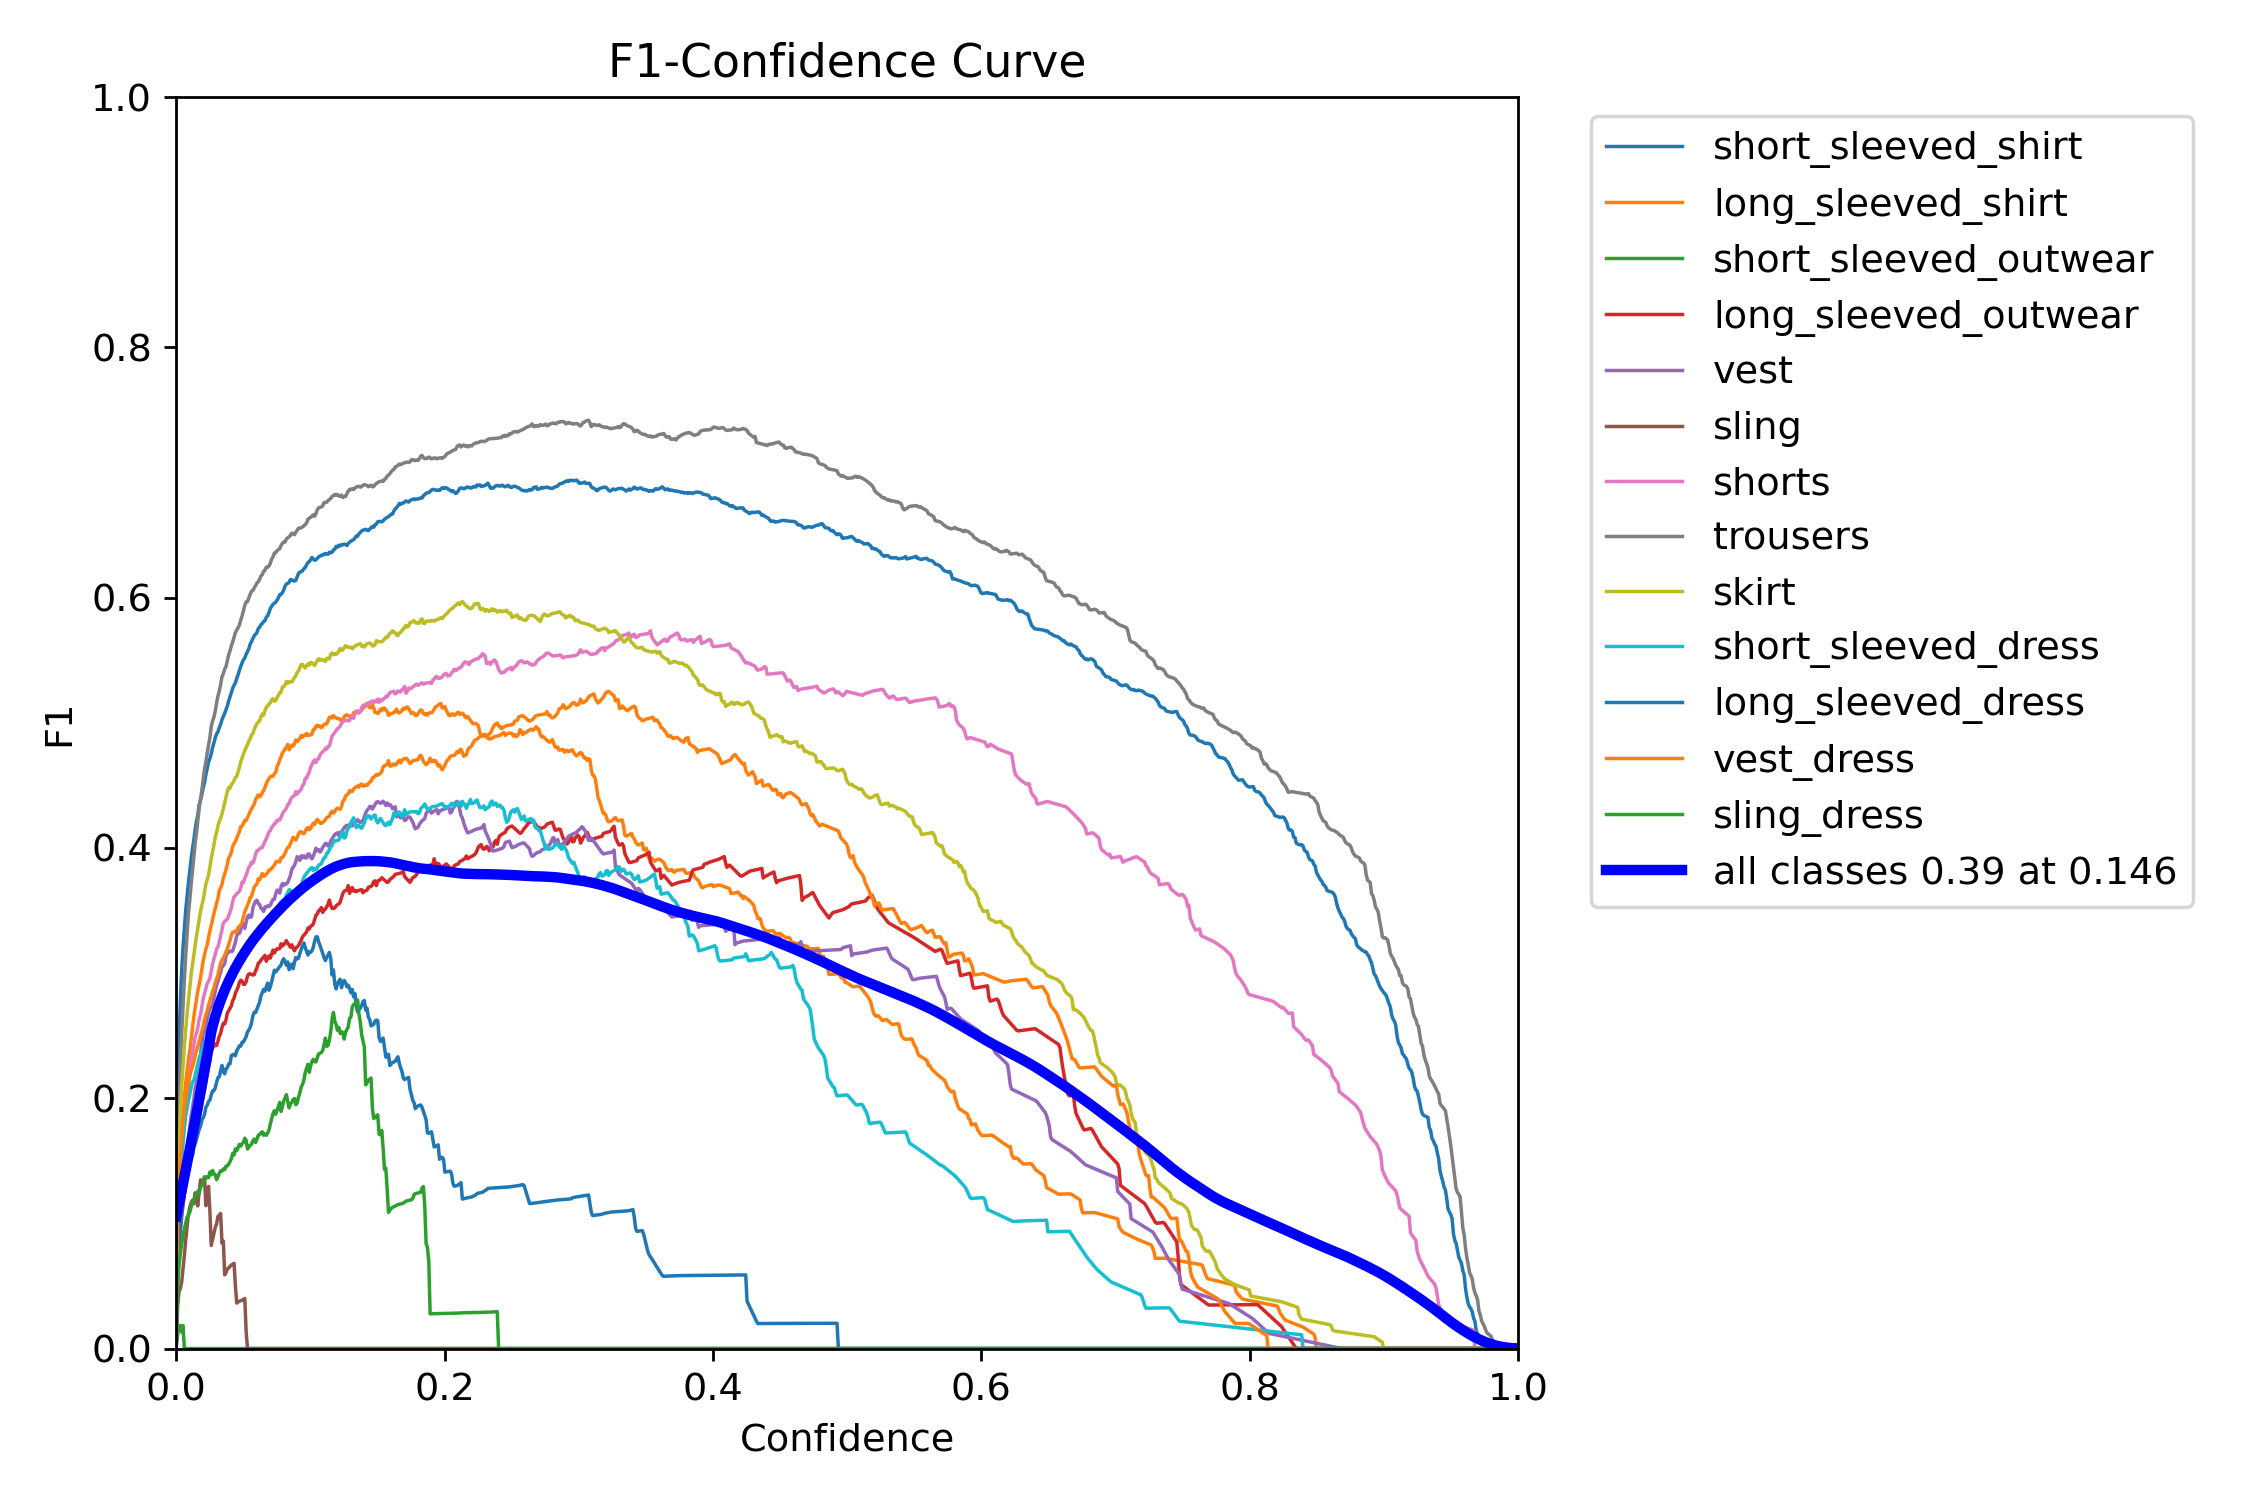

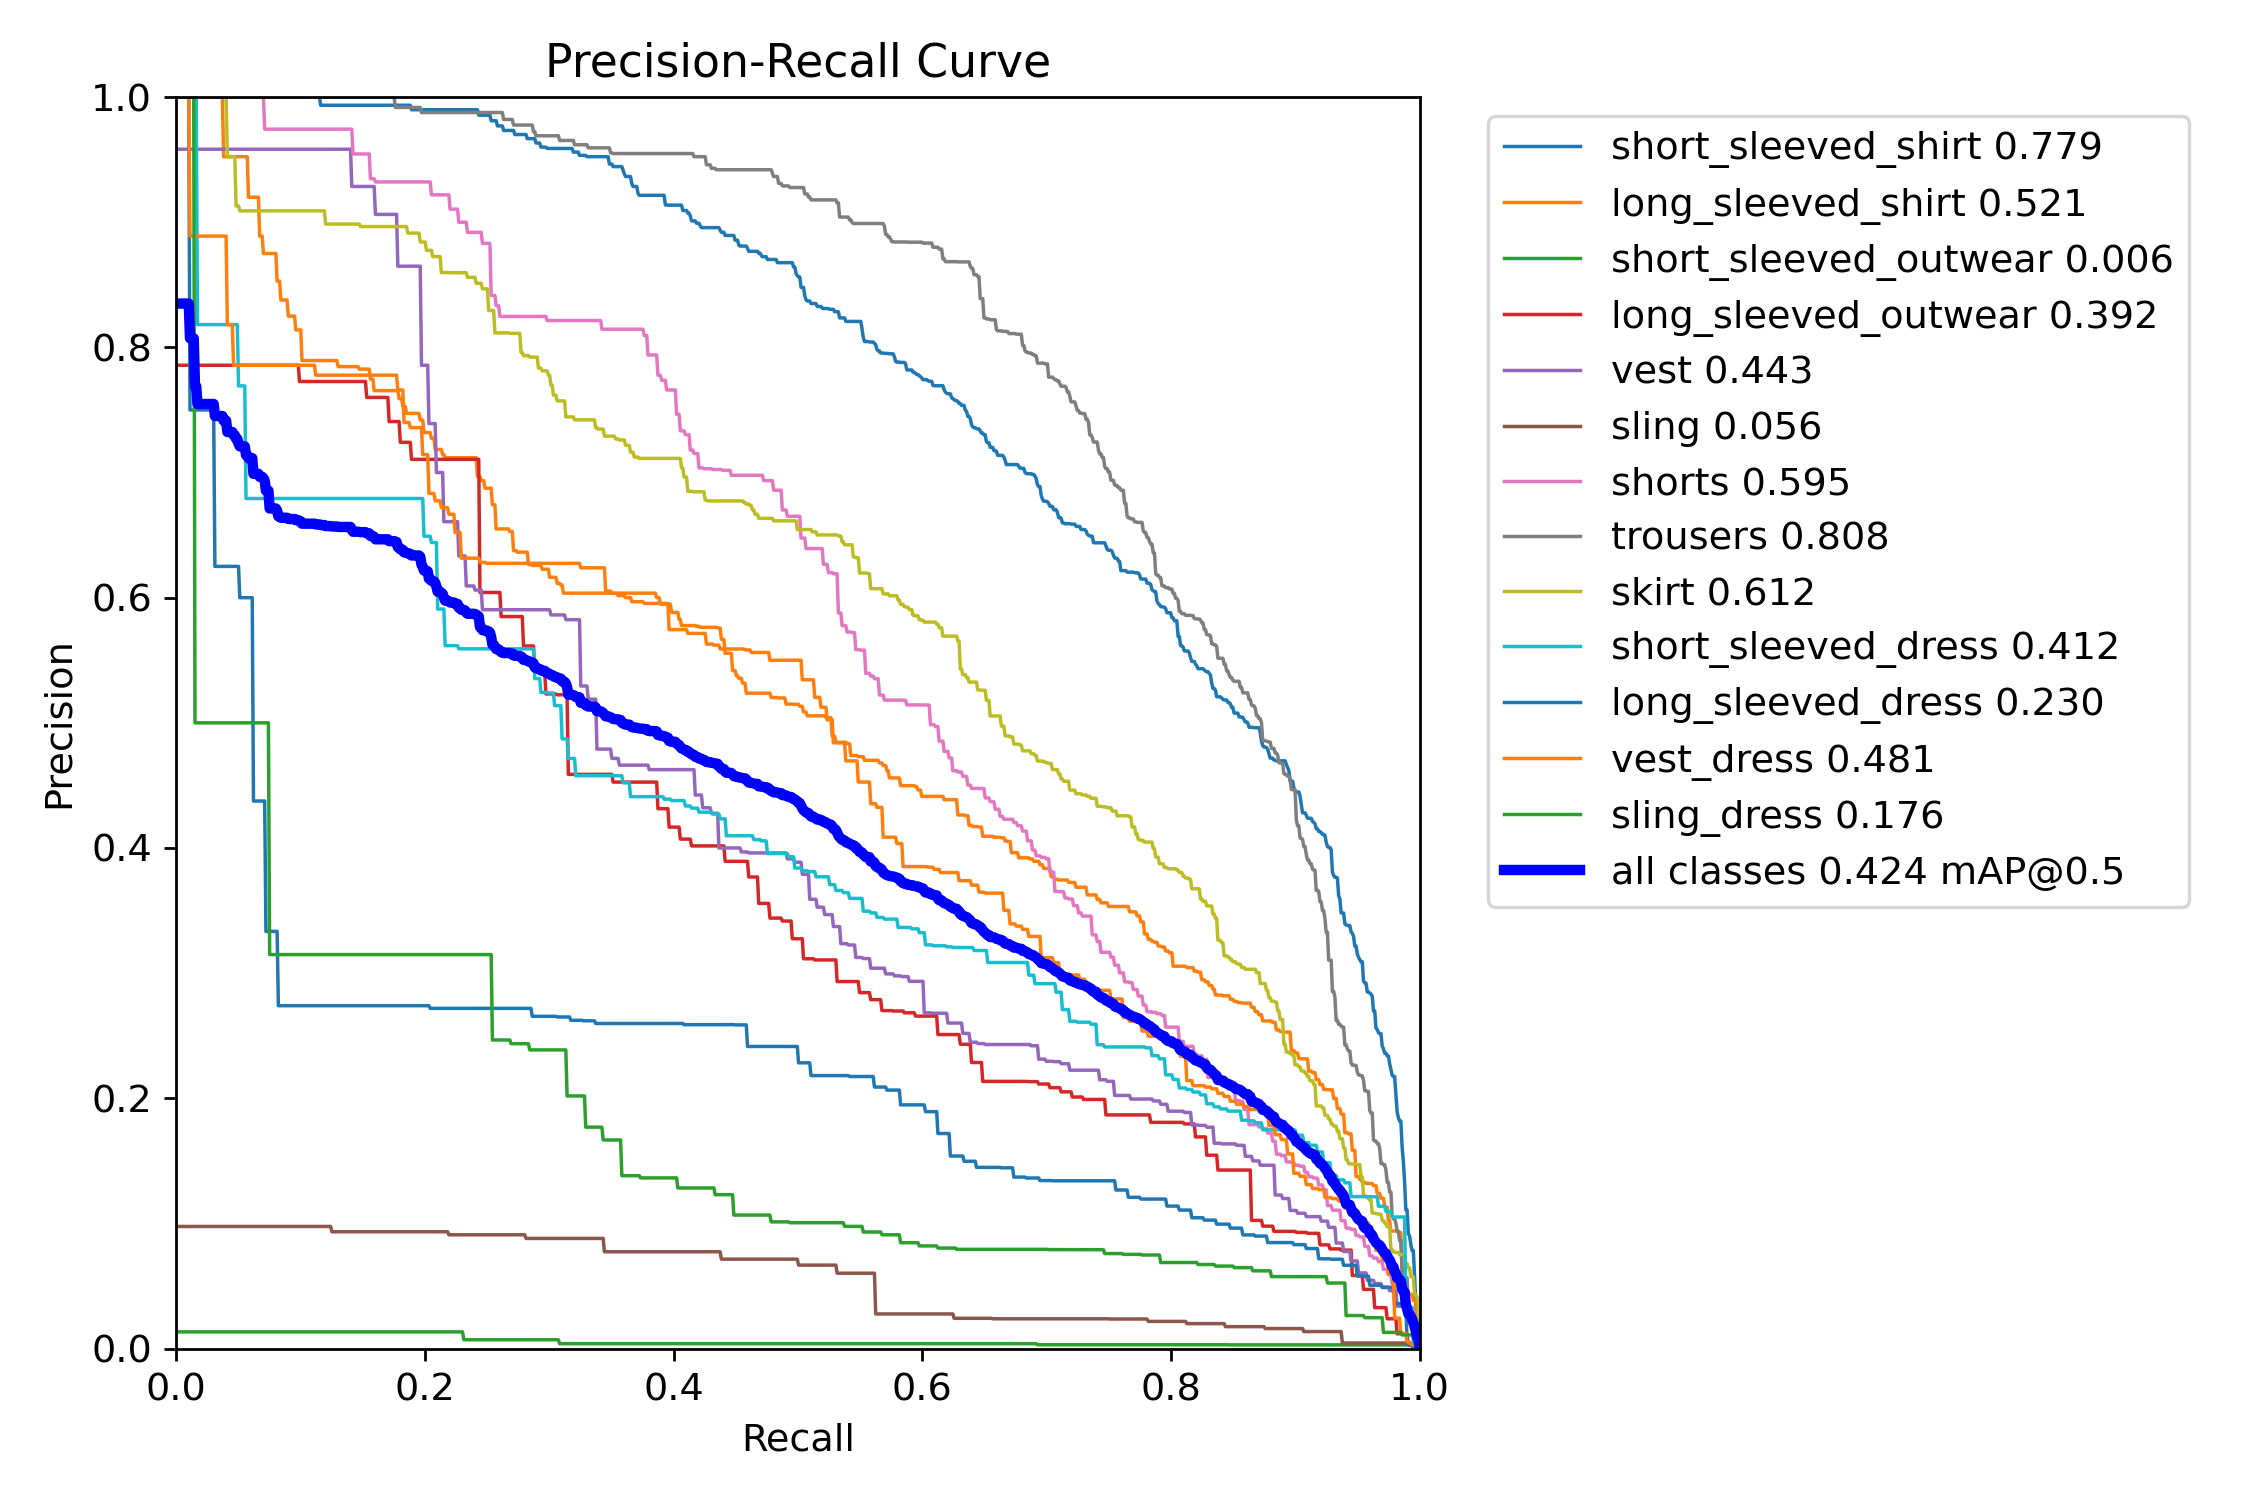

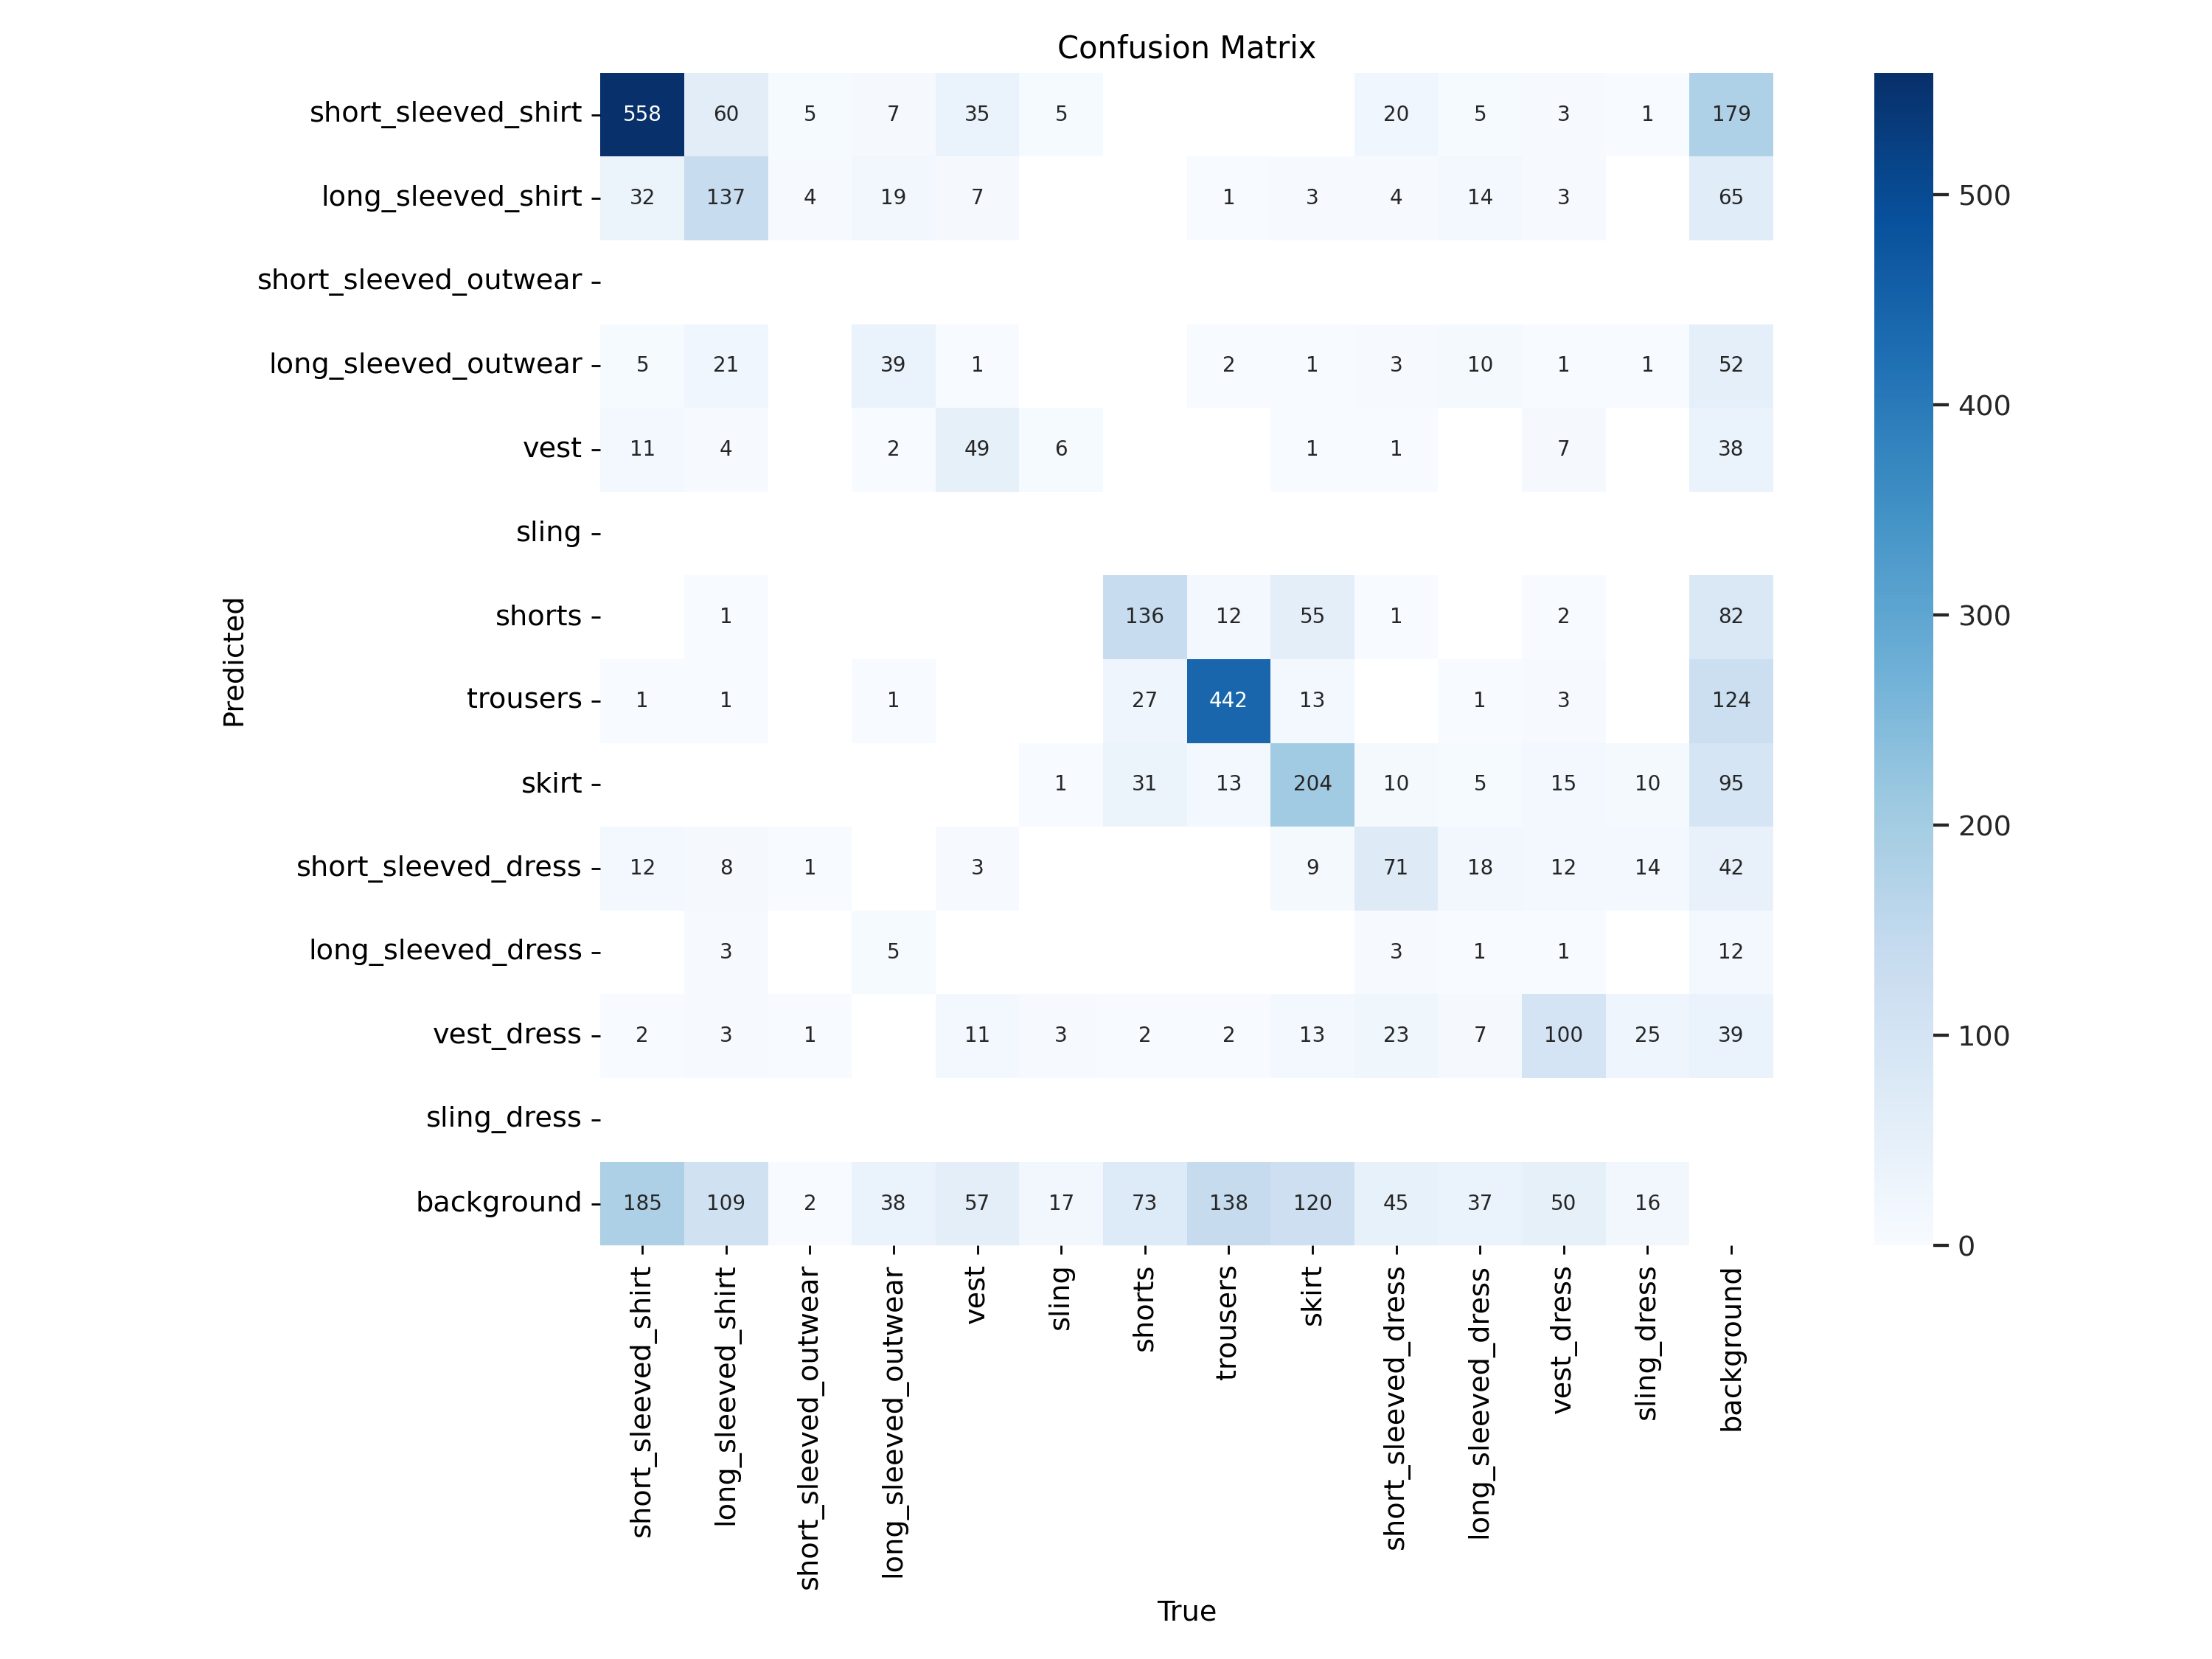

In [ ]:
from IPython.display import Image
from IPython.display import display
x = Image(filename='/content/runs/detect/train2/F1_curve.png')
y = Image(filename='/content/runs/detect/train2/PR_curve.png')
z = Image(filename='/content/runs/detect/train2/confusion_matrix.png')
display(x, y,z)

## **Saving the model and other related files in the personal drive**

We first need to mount our google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Then we can copy the whole folder of trained model to our drive for using it later.

In [ ]:
import shutil
source_folder = '/content/runs'  # This is the source folder in Colab
destination_folder = '/content/drive/MyDrive/CV/runs'  # Desired location in Google Drive

shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/CV/runs3'

## **Crop the clothes**

install required

In [ ]:
!pip install ultralytics
from ultralytics import YOLO
model = YOLO("best.pt")

We need to choose an image or more by path. At first we do it with just one image.

In [ ]:
image_path='/content/T01.jpg'

After that we start using the model and detect the clothes.

In [ ]:
results =model.predict(image_path)


image 1/1 /content/T01.jpg: 352x640 1 long_sleeved_shirt, 1 long_sleeved_outwear, 1 trousers, 1 skirt, 1 vest_dress, 1 sling_dress, 153.3ms
Speed: 14.3ms preprocess, 153.3ms inference, 794.9ms postprocess per image at shape (1, 3, 352, 640)


The result is in the list. For just one clothes we use only the first cell.

In [ ]:
results=results[0]

### Visualizing the results

We can see the result first.

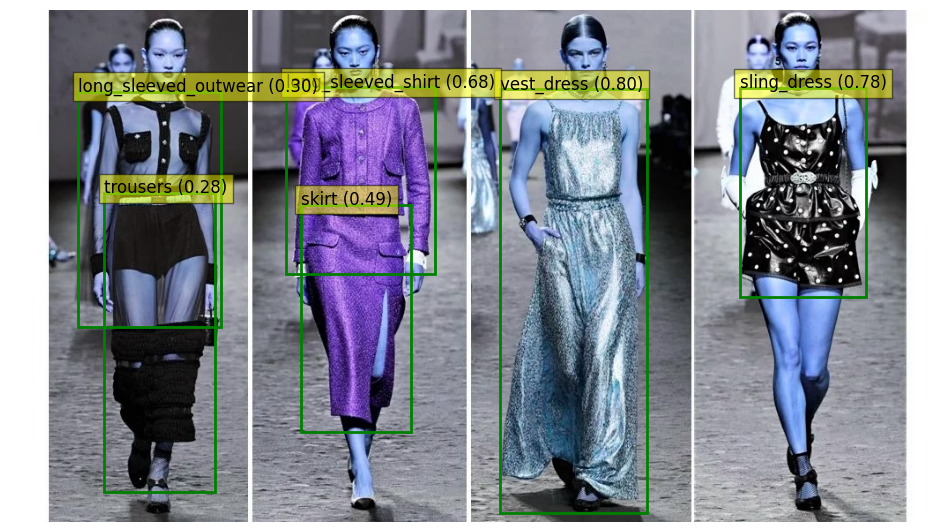

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Extract the original image
orig_img = results.orig_img

# Extract the bounding boxes, class IDs, and confidence scores
boxes = results.boxes.xyxy.cpu().numpy() # Convert tensor to numpy array
class_ids = results.boxes.cls.cpu().numpy()  # Convert tensor to numpy array
confidences = results.boxes.conf.cpu().numpy()   # Convert tensor to numpy array

# Extract the class names
names = results.names

# Create a figure and axis
fig, ax = plt.subplots(1, figsize=(12, 8))

# Display the image
ax.imshow(orig_img)

# Iterate over the bounding boxes and draw them on the image
for box, class_id, confidence in zip(boxes, class_ids, confidences):
    x_min, y_min, x_max, y_max = box[:4]
    label = names[int(class_id)]

    # Create a rectangle patch
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='g', facecolor='none')

    # Add the rectangle patch to the axis
    ax.add_patch(rect)

    # Add the label
    plt.text(x_min, y_min, f"{label} ({confidence:.2f})", fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

# Show the plot
plt.axis('off')
plt.show()


Cropping and saving the images and a csv file to gather data on catagories.

In [ ]:
import numpy as np
import cv2
import os

# Extract the original image
orig_img = results.orig_img

# Extract the bounding boxes, class IDs, and confidence scores
boxes = results.boxes.xyxy.cpu().numpy()  # Convert tensor to numpy array
class_ids = results.boxes.cls.cpu().numpy()  # Convert tensor to numpy array
confidences = results.boxes.conf.cpu().numpy()  # Convert tensor to numpy array

# Extract pic file name
file_name = os.path.splitext(os.path.basename(image_path))[0]

# List to store data for the CSV
data = []

# Extract the class names
names = results.names

# Directory to save cropped images
save_dir = 'cropped_images'
os.makedirs(save_dir, exist_ok=True)

# Iterate over the bounding boxes and crop the regions from the original image
for idx, (box, class_id, confidence) in enumerate(zip(boxes, class_ids, confidences)):
    x_min, y_min, x_max, y_max = map(int, box[:4])  # Convert coordinates to integers

    # Crop the region from the original image
    cropped_img = orig_img[y_min:y_max, x_min:x_max]

    # Create a filename for the cropped image
    class_name = names[int(class_id)]
    filename = f"{file_name}_{class_name}_{idx}.jpg"
    filepath = os.path.join(save_dir, filename)

    # Save the cropped image
    cv2.imwrite(filepath, cropped_img)
    print(f"Saved cropped image: {filepath}")

    # Collect data for CSV
    data.append({
        'Category': names[int(class_id)],
        'confidence': confidence,
        'file_name' : filename,
        'Image_Path' : filepath
    })

print("Cropping and saving completed.")

# Create a DataFrame
df = pd.DataFrame(data)
csv_file_path = 'detected_clothes.csv'

  # Check if the CSV file already exists
if os.path.isfile(csv_file_path):
    # If it exists, append data without writing headers
  df.to_csv(csv_file_path, mode='a', header=False, index=False)
else:
    # If it does not exist, create a new file with headers
  df.to_csv(csv_file_path, mode='w', header=True, index=False)

print(f"Data saved to {csv_file_path}")

Saved cropped image: cropped_images/T01_vest_dress_0.jpg
Saved cropped image: cropped_images/T01_sling_dress_1.jpg
Saved cropped image: cropped_images/T01_long_sleeved_shirt_2.jpg
Saved cropped image: cropped_images/T01_skirt_3.jpg
Saved cropped image: cropped_images/T01_long_sleeved_outwear_4.jpg
Saved cropped image: cropped_images/T01_trousers_5.jpg
Cropping and saving completed.
Data saved to detected_clothes.csv


And we can use our model to detect a few picures at once. First we need to save all the paths to the desired images in a list.

In [ ]:
import glob
import cv2

image_paths = glob.glob("/content/picture/*.jpg")
images = [cv2.imread(image_path) for image_path in image_paths]


Then we just give our list to the model.

In [ ]:
results =model.predict(image_paths)


0: 640x640 1 trousers, 3.7ms
1: 640x640 1 short_sleeved_shirt, 3.7ms
2: 640x640 1 skirt, 3.7ms
3: 640x640 1 short_sleeved_shirt, 3.7ms
4: 640x640 1 vest_dress, 3.7ms
5: 640x640 1 shorts, 3.7ms
6: 640x640 1 long_sleeved_shirt, 3.7ms
7: 640x640 1 sling_dress, 3.7ms
8: 640x640 1 trousers, 3.7ms
9: 640x640 1 short_sleeved_shirt, 1 long_sleeved_shirt, 3.7ms
10: 640x640 1 long_sleeved_shirt, 3.7ms
11: 640x640 1 short_sleeved_dress, 3.7ms
12: 640x640 1 short_sleeved_shirt, 1 long_sleeved_shirt, 3.7ms
13: 640x640 1 vest, 3.7ms
14: 640x640 1 vest, 3.7ms
15: 640x640 1 trousers, 3.7ms
16: 640x640 1 shorts, 3.7ms
17: 640x640 1 trousers, 3.7ms
18: 640x640 1 shorts, 3.7ms
19: 640x640 1 trousers, 1 sling_dress, 3.7ms
20: 640x640 1 vest_dress, 3.7ms
21: 640x640 1 skirt, 1 sling_dress, 3.7ms
22: 640x640 1 short_sleeved_shirt, 1 sling_dress, 3.7ms
23: 640x640 1 long_sleeved_shirt, 3.7ms
24: 640x640 1 vest, 3.7ms
25: 640x640 1 long_sleeved_dress, 1 vest_dress, 3.7ms
26: 640x640 1 vest, 3.7ms
27: 640x640

Now we have a list of results.

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd

csv_file_path = 'detected_clothes.csv'
  # List to store data for the CSV
data = []
for ndx,res in enumerate(results):
  
  # Extract the original image
  orig_img = res.orig_img

  # Extract the bounding boxes, class IDs, and confidence scores
  boxes = res.boxes.xyxy.cpu().numpy()  # Convert tensor to numpy array
  class_ids = res.boxes.cls.cpu().numpy()  # Convert tensor to numpy array
  confidences = res.boxes.conf.cpu().numpy()  # Convert tensor to numpy array

  # Extract pic file name
  file_name = os.path.splitext(os.path.basename(image_paths[ndx]))[0]

  # Extract the class names
  names = res.names

  # Directory to save cropped images
  save_dir = 'cropped_images'
  os.makedirs(save_dir, exist_ok=True)

  # Iterate over the bounding boxes and crop the regions from the original image
  for idx, (box, class_id, confidence) in enumerate(zip(boxes, class_ids, confidences)):
      x_min, y_min, x_max, y_max = map(int, box[:4])  # Convert coordinates to integers

      # Crop the region from the original image
      cropped_img = orig_img[y_min:y_max, x_min:x_max]

      # Create a filename for the cropped image
      class_name = names[int(class_id)]
      filename = f"{file_name}_{class_name}_{idx}.jpg"
      filepath = os.path.join(save_dir, filename)

      # Save the cropped image
      cv2.imwrite(filepath, cropped_img)
      print(f"Saved cropped image: {filepath}")

      # Collect data for CSV
      data.append({
          'Category': names[int(class_id)],
          'confidence': confidence,
          'file_name' : filename,
          'Image_Path' : filepath
      })

  print("Cropping and saving completed.")

  # Create a DataFrame
  df = pd.DataFrame(data)
    # Check if the CSV file already exists
  if os.path.isfile(csv_file_path):
      # If it exists, append data without writing headers
    df.to_csv(csv_file_path, mode='a', header=False, index=False)
  else:
      # If it does not exist, create a new file with headers
    df.to_csv(csv_file_path, mode='w', header=True, index=False)

  print(f"Data saved to {csv_file_path}")


Saved cropped image: /content/picture/29.jpg_trousers_0.jpg
Cropping and saving completed.
Data saved to detected_clothes.csv
Saved cropped image: /content/picture/11.jpg_short_sleeved_shirt_0.jpg
Cropping and saving completed.
Data saved to detected_clothes.csv
Saved cropped image: /content/picture/33.jpg_skirt_0.jpg
Cropping and saving completed.
Data saved to detected_clothes.csv
Saved cropped image: /content/picture/1.jpg_short_sleeved_shirt_0.jpg
Cropping and saving completed.
Data saved to detected_clothes.csv
Saved cropped image: /content/picture/22.jpg_vest_dress_0.jpg
Cropping and saving completed.
Data saved to detected_clothes.csv
Saved cropped image: /content/picture/27.jpg_shorts_0.jpg
Cropping and saving completed.
Data saved to detected_clothes.csv
Saved cropped image: /content/picture/41.jpg_long_sleeved_shirt_0.jpg
Cropping and saving completed.
Data saved to detected_clothes.csv
Saved cropped image: /content/picture/45.jpg_sling_dress_0.jpg
Cropping and saving complet

### We can remove the background from the pictures

In [ ]:
pip install rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 16.3 MB/s eta 0:00:00


In [ ]:
from rembg import remove
from PIL import Image

input_img = Image.open("/content/cropped_images/long_sleeved_outwear_4_conf_0.30.jpg")
output_img = remove(input_img)
output_img.save("output.png")

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 108GB/s]


## Random clothing

In this part we suggest an outfit for you based on the weather.

In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get user input for temperature category
temp_category = input("Please choose Cold or Warm as your temperature category: ")

# Define clothing categories based on temperature
categories_warm_1 = ["short_sleeved_shirt", "short_sleeved_outwear"]
categories_warm_2 = ["shorts", "trousers", "skirt"]
categories_warm_3 = ["short_sleeved_dress", "vest_dress", "sling_dress"]
categories_cold_1 = ["long_sleeved_shirt", "long_sleeved_outwear"]
categories_cold_2 = ["trousers"]
categories_cold_3 = ["long_sleeved_dress"]
extra = ["sling", "vest"]

# Read the CSV file containing detected clothes
df = pd.read_csv("detected_clothes.csv")

# Create a dictionary where each key is a clothing category and each value is a list of image paths
category_dict = df.groupby('Category')['Image_Path'].apply(list).to_dict()

# Initialize variables for image paths
up_img = ""
down_img = ""
full_img = ""
sling_img = ""
vest_img = ""

# Print an example image path for debugging purposes
print(category_dict["long_sleeved_shirt"][1])

# Function to randomly choose an item in a specific category list
def get_random_item(category_list):
    try:
        return random.choice(category_list)
    except IndexError:
        return None

# Randomly select clothing items based on the temperature category
if temp_category == 'Cold':
    # Randomly choose between two types of clothing combinations
    n = random.randint(1, 2)
    if n == 1:
        # Select an upper and a lower clothing item
        cold_1 = random.randint(0, 1)
        up_img = get_random_item(category_dict.get(categories_cold_1[cold_1], []))
        down_img = get_random_item(category_dict.get(categories_cold_2[0], []))
        
    else:
        # Select a full-body clothing item
        full_img = get_random_item(category_dict.get(categories_cold_3[0], []))
        
elif temp_category == "Warm":
    # Randomly choose between two types of clothing combinations
    n = random.randint(1, 2)
    if n == 1:
        # Select an upper and a lower clothing item
        warm_1 = random.randint(0, 1)
        up_img = get_random_item(category_dict.get(categories_warm_1[warm_1], []))
        warm_2 = random.randint(0, 2)
        down_img = get_random_item(category_dict.get(categories_warm_2[warm_2], []))
    else:
        # Select a full-body clothing item
        warm_3 = random.randint(0, 2)
        full_img = get_random_item(category_dict.get(categories_warm_3[warm_3], []))
else:
    # Handle incorrect input
    print("Wrong input temperature Category!")

# Select a random extra item (sling or vest)
sling_img = get_random_item(category_dict.get("sling", []))
vest_img = get_random_item(category_dict.get("vest", []))

# Function to display clothing
def display_image(image_path, title):
    if image_path:
        image = mpimg.imread(image_path)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()

# Display the selected images
display_image(up_img, "Upper Clothing")
display_image(down_img, "Lower Clothing")
display_image(full_img, "Full-body Clothing")
display_image(sling_img, "Sling")
display_image(vest_img, "Vest")
    